In [1]:
import numpy as np
import pickle
from astropy.io import fits
import astropy.units as u
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import copy

import falco
import proper
proper.prop_use_fftw(DISABLE=True)
import roman_phasec_proper as phasec

import misc

import falco_utils as fu
import falco_hlc_band1_setup_config as config
reload(config)
reload(fu)

npsf = 64

pyFFTW not found, using Numpy FT.


In [2]:
label = 'hlc_band1_best_pwp-bp_bw0.01_lr_10itr_v1'

mp = fu.load_pickle(label)
out = fu.load_pickle(label + '_snippet.pkl')

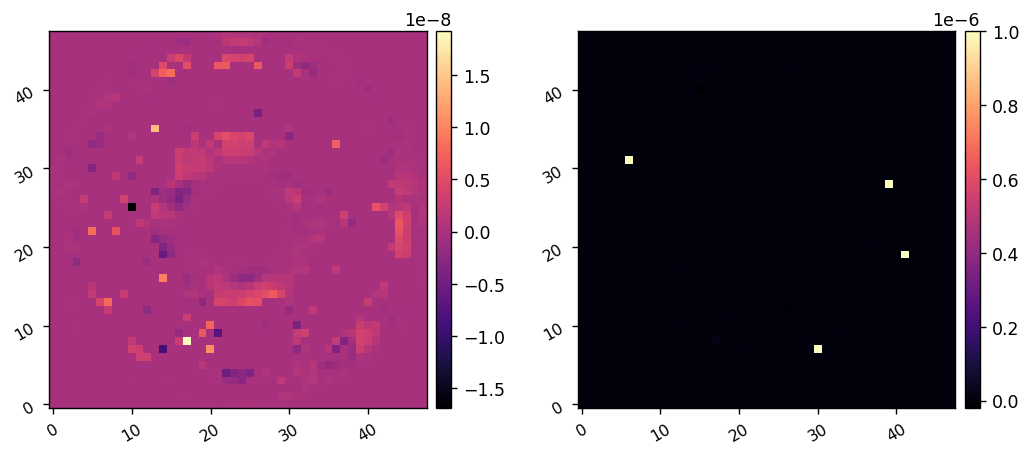

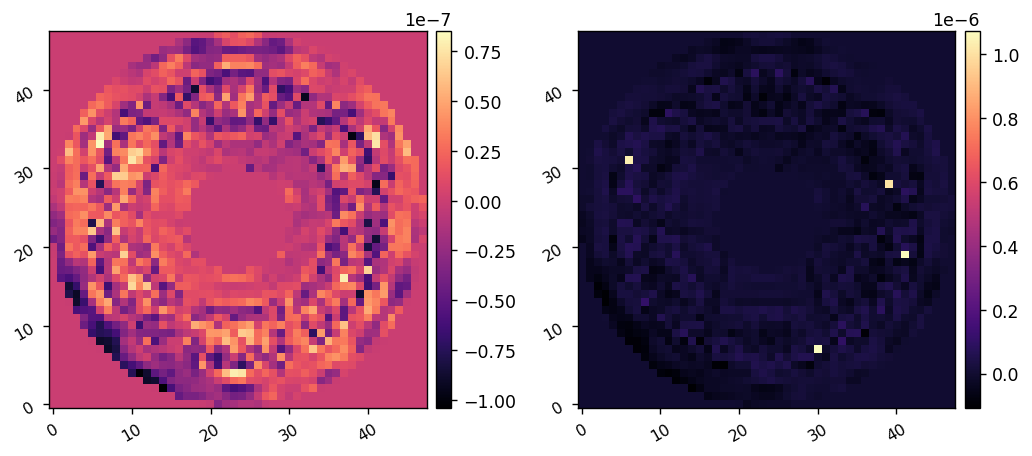

In [3]:
falco_dm1_final = out.dm1.Vall[:,:,-1]*mp.dm1.VtoH
falco_dm2_final = out.dm2.Vall[:,:,-1]*mp.dm2.VtoH 

misc.myimshow2(falco_dm1_final, falco_dm2_final)
misc.myimshow2(falco_dm1_final + mp.full.dm1.flatmap, falco_dm2_final + mp.full.dm2.flatmap)

In [4]:
dm1_m, dm2_m = (falco_dm1_final + mp.full.dm1.flatmap, falco_dm2_final + mp.full.dm2.flatmap)

lam_array = np.array([mp.lambda0*1e6])

options = {'cor_type':mp.full.cor_type,
           'final_sampling_lam0':mp.full.final_sampling_lam0, 
           'source_x_offset':0,
           'use_errors': mp.full.use_errors,
           'use_lens_errors':mp.full.use_lens_errors,
           'use_dm1':1, 'dm1_m':dm1_m, 
           'use_dm2':1, 'dm2_m':dm2_m,
           'use_field_stop':mp.full.use_field_stop, 
           'field_stop_radius_lam0': mp.full.field_stop_radius_lam0,
           'polaxis':mp.full.polaxis,
          }

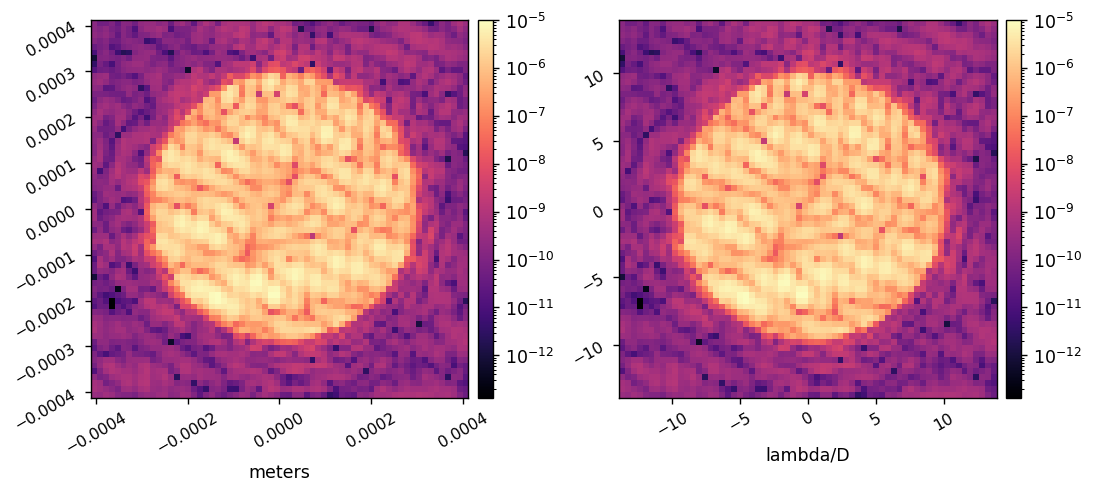

In [5]:
(wfs, wfs_sampling_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=True, PASSVALUE=options)

psfs = np.abs(wfs)**2
psf = psfs[0]
psf_pixelscale = wfs_sampling_m[0]*u.m/u.pix

misc.myimshow2(psf, psf, lognorm1=True, lognorm2=True, pxscl1=psf_pixelscale, pxscl2=mp.full.final_sampling_lam0,)

# Define zones for evaluating contrast.

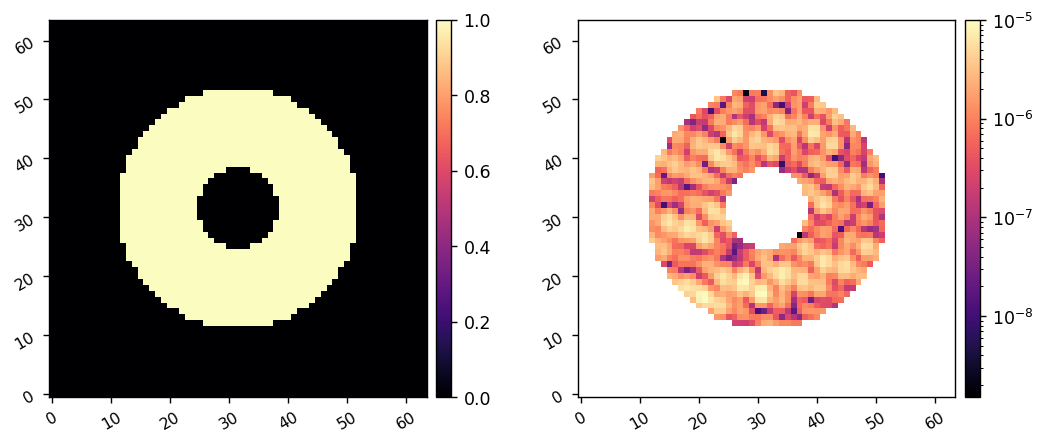

In [6]:
dh_params = {
    'inner_radius' : mp.Fend.score.Rin, 'outer_radius' : mp.Fend.score.Rout,
    'edge_position' : 0, 'direction' : mp.Fend.sides,
}

mask = fu.create_annular_mask(dh_params, mp, npsf)
misc.myimshow2(mask, psf*mask, lognorm2=True)

zone_radii = np.linspace(mp.Fend.score.Rin, mp.Fend.score.Rout, 
                         int(np.round(mp.Fend.score.Rout-mp.Fend.score.Rin) + 1))
zone_params = {
    'inner_radius' : zone_radii[0], 'outer_radius' : zone_radii[1],
    'edge_position' : 0, 'direction' : 'r',
}

# Compute an off-axis PSF for each zone

In [7]:
opts = []
for i in range(len(zone_radii)-1):
    options.update({'source_x_offset':(zone_radii[i] + zone_radii[i+1])/2-0.5})
    opts.append( copy.copy(options) )
    print(opts[i]['source_x_offset'])
    
(wfs, wfs_sampling_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=True, PASSVALUE=opts)
psfs = np.abs(wfs)**2
psf_offax = psfs[0]
offax_psfs = np.abs(wfs)**2

[3.]
[4.]
[5.]
[6.]
[7.]
[8.]


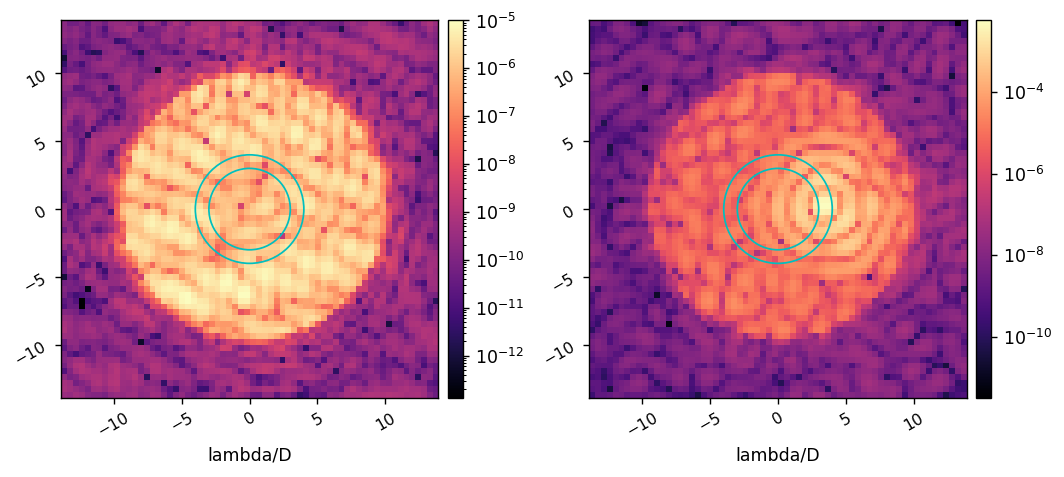

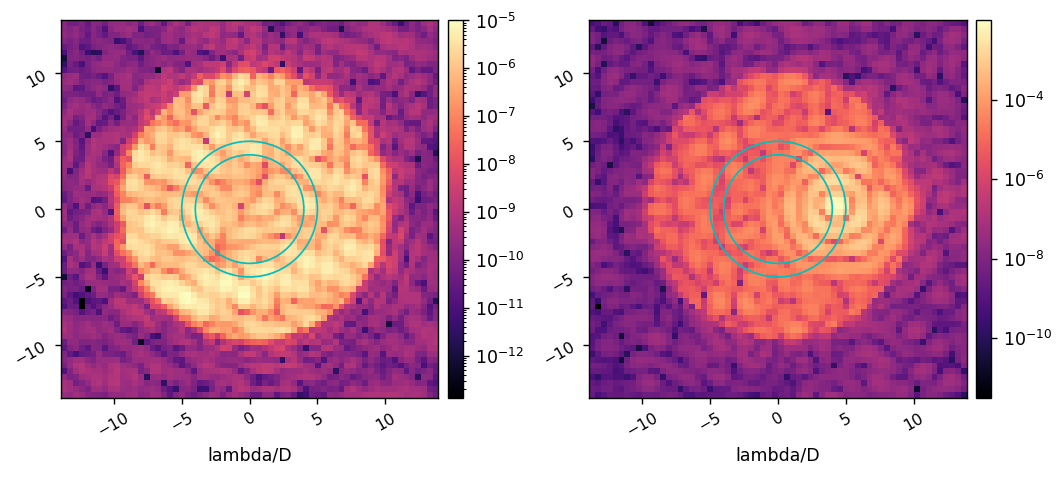

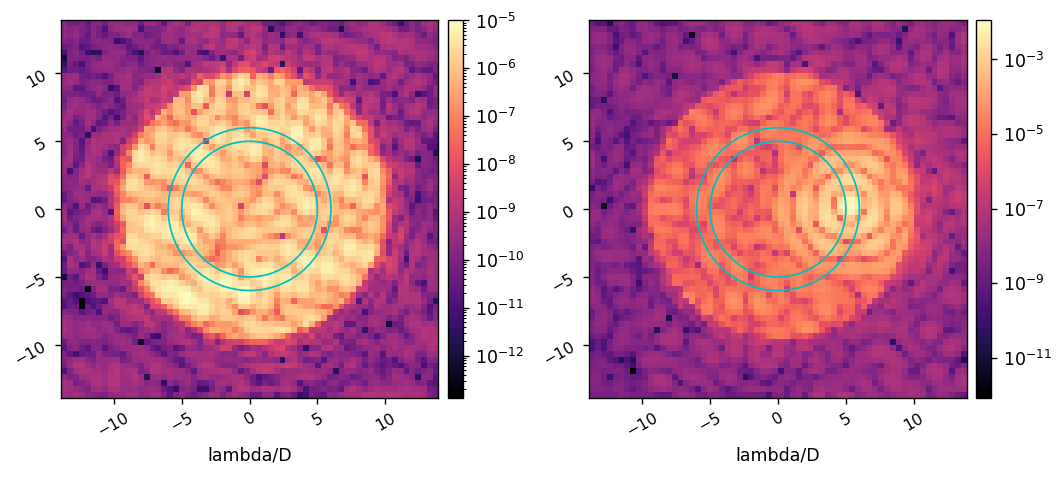

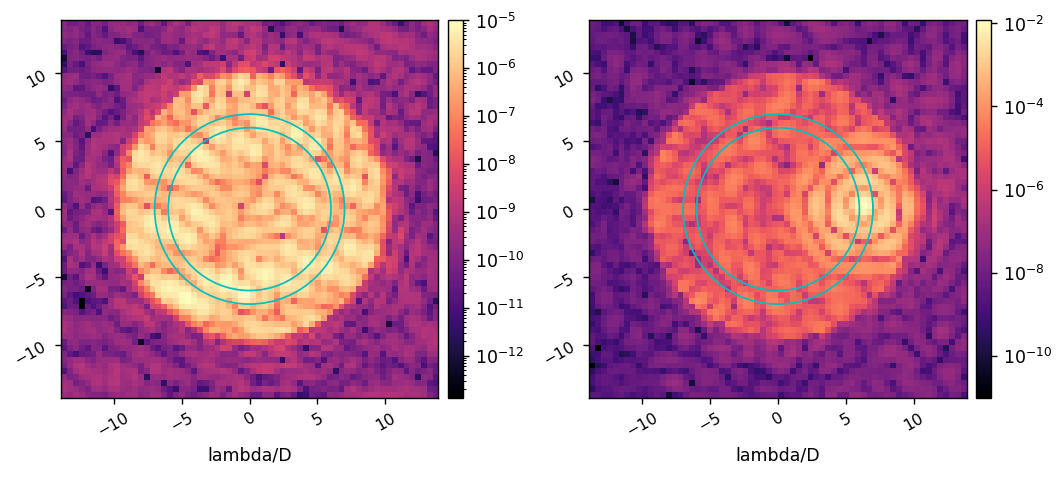

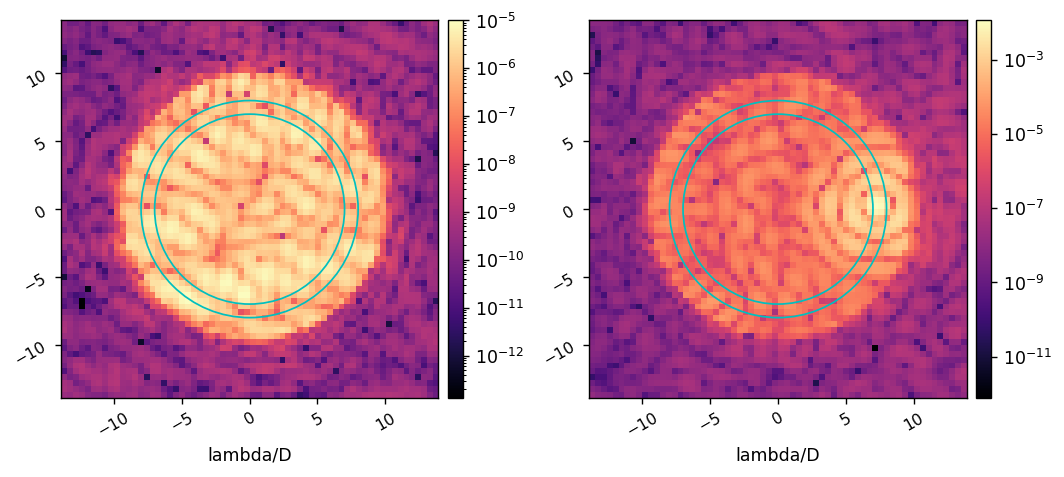

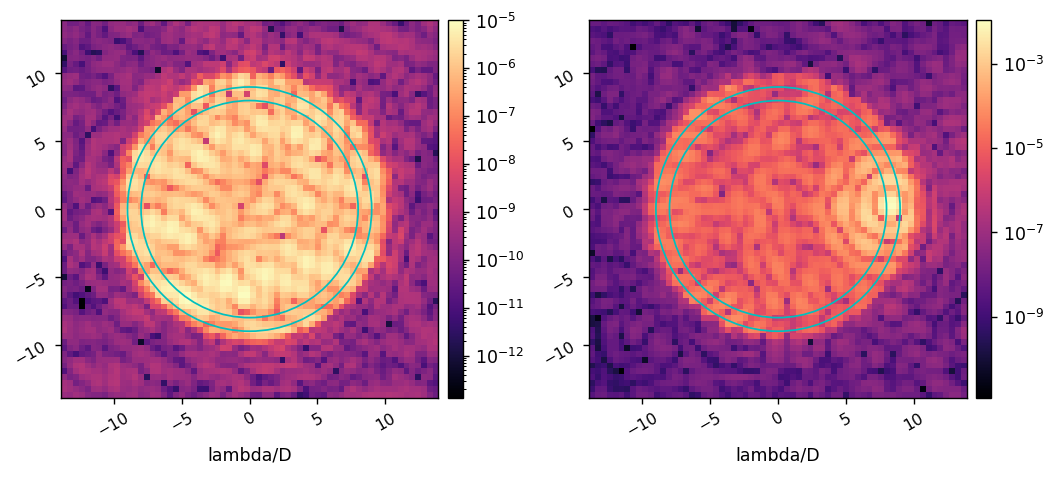

╒════════╤════════════════╤════════════════╤═════════════════════╕
│   Zone │   Inner Radius │   Outer Radius │   Zone Avg Contrast │
╞════════╪════════════════╪════════════════╪═════════════════════╡
│      0 │            3.0 │            4.0 │           2.374e-04 │
├────────┼────────────────┼────────────────┼─────────────────────┤
│      1 │            4.0 │            5.0 │           2.089e-04 │
├────────┼────────────────┼────────────────┼─────────────────────┤
│      2 │            5.0 │            6.0 │           1.800e-04 │
├────────┼────────────────┼────────────────┼─────────────────────┤
│      3 │            6.0 │            7.0 │           1.939e-04 │
├────────┼────────────────┼────────────────┼─────────────────────┤
│      4 │            7.0 │            8.0 │           1.270e-04 │
├────────┼────────────────┼────────────────┼─────────────────────┤
│      5 │            8.0 │            9.0 │           1.233e-04 │
╘════════╧════════════════╧════════════════╧══════════════════

In [8]:
show_zones = 1

zone_contrasts = []
for i in range(len(zone_radii)-1):
    zone_params.update({'inner_radius' : zone_radii[i], 'outer_radius' : zone_radii[i+1],})
    zone_mask = fu.create_annular_mask(zone_params, mp, npsf)
    psf_zone = zone_mask*psf
    zone_avg_flux = np.sum(psf_zone)/zone_mask.sum()
    
    zone_avg_contrast = zone_avg_flux/ np.max(offax_psfs[i])
    zone_contrasts.append(zone_avg_contrast)
    
    if show_zones:
        patches1 = fu.create_circ_patches(zone_params)
        patches2 = fu.create_circ_patches(zone_params)
        misc.myimshow2(psf, offax_psfs[i], lognorm1=True, lognorm2=True, 
                       pxscl1=mp.full.final_sampling_lam0, pxscl2=mp.full.final_sampling_lam0,
                       patches1=patches1, patches2=patches2)
    
fu.zone_table(zone_radii, zone_contrasts)

AttributeError: 'types.SimpleNamespace' object has no attribute 'DM1V'

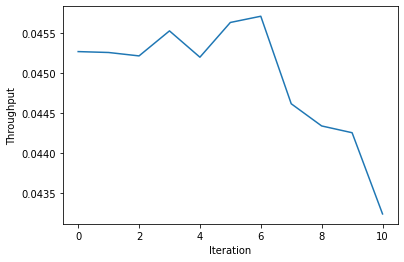

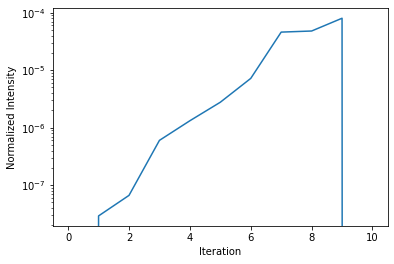

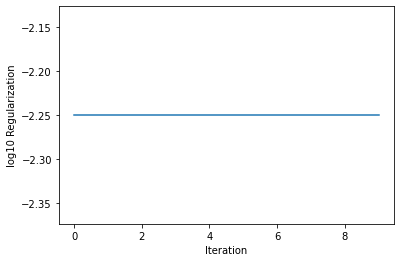

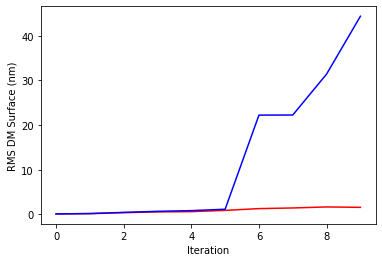

<Figure size 432x288 with 0 Axes>

In [9]:
# Load results and plot the output data from pickled data
output_fname = fu.output_dir/(label + '_snippet.pkl')
falco.plot.plot_trial_output_from_pickle(str(output_fname))